# use another position
- initial_state2, 2nd last is flipped
- has 2 circuits instead of 3 circuits.  11/16/2022
- integrate early termination if obj does not change for 5 iterations.

In [1]:
# !pip install pennylane
# !pip install pennylane-qiskit

In [2]:
# !pip install pennylane-lightning

In [3]:
# !pip install pennylane-lightning[gpu]  # has erro

In [4]:
import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as qml_np
import pennylane as qml

import math
import matplotlib.pyplot as plt
import datetime

In [5]:
qml.about()

Name: PennyLane
Version: 0.26.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: c:\users\user\anaconda3\lib\site-packages
Requires: semantic-version, networkx, appdirs, numpy, toml, autoray, pennylane-lightning, cachetools, scipy, autograd, retworkx
Required-by: PennyLane-qiskit, PennyLane-Lightning

Platform info:           Windows-10-10.0.19041-SP0
Python version:          3.8.8
Numpy version:           1.20.1
Scipy version:           1.6.2
Installed devices:
- default.gaussian (PennyLane-0.26.0)
- default.mixed (PennyLane-0.26.0)
- default.qubit (PennyLane-0.26.0)
- default.qubit.autograd (PennyLane-0.26.0)
- default.qubit.jax (PennyLane-0.26.0)
- default.qubit.tf (PennyLane-0.26.0)
- default.qubit.torch (PennyLane-0.26.0)
- default.qutrit (PennyLane-0.26.0)
- qiskit.aer (PennyLane-qiskit-0.24.0)
- qiskit.basicaer (PennyLane-qiskit-0.2

# 2nd last flipped

In [6]:
num_of_qubits = 1+9
eps_val_q = 1/math.sqrt(2**num_of_qubits)/100
eps_val = min(1e-10, eps_val_q)
tiny_change_threshold = 1e-4
cnt_threshold_no_change = 5

N = 2**(num_of_qubits-2)
normal_val = math.sqrt(1/N)
# initial_state_phi1 = [math.sqrt(1/N)]*(N-1) + [0]*N + [math.sqrt(1/N)] # 2**(num_of_qubits-1)
# initial_state_phi1 = [.5,.5,.5, 0,   0, 0, 0, .5,  ] # 2**(num_of_qubits-1)

initial_state2 = [1/math.sqrt(N)]*(N-2) + [0, 1/math.sqrt(N)] + [0]*(N-2) + [1/math.sqrt(N), 0] # 2**(num_qubits-1)
initial_state_phi1 = initial_state2
print(f'initial_state_phi1={initial_state_phi1}')
# print(f'initial_state_phi1={initial_state_phi1[-5:]}')
initial_state_0_phi1  = initial_state_phi1 + [0]*len(initial_state_phi1) # 2**num_of_qubits


# print(f'initial_state3={initial_state3}')
# initial_state  = initial_state3 + [0]*len(initial_state3) # 2**num_qubits

initial_state_phi1=[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.06

In [7]:
## three quantum circuits
def layer_with_HT(theta):
    for i in range(num_of_qubits-1):
        qml.CRY(theta[i], wires=(0,i+1))
    for i in range(num_of_qubits-2):
        qml.Toffoli(wires=(0,i+1,i+2))

        
def layer_no_HT(theta, qubit_posi):
    for i in range(num_of_qubits-1):
        qml.RY(theta[i], wires=(qubit_posi[i]))
    for i in range(num_of_qubits-2):
        qml.CNOT(wires=(qubit_posi[i],qubit_posi[i+1]))
    
# # qml.MultiControlledX(wires=[0,1,2], control_values='11')
# def initiate_state_0_phi1(qml, qubit_position, work_wires):
#     for i in qubit_position[1:]: # range(num_of_qubits-2):
#         qml.Hadamard(i)
#     qp = qubit_position[1:] + [qubit_position[0]]
#     qml.MultiControlledX(wires=qp, work_wires=work_wires)
#     # circ2 = MCMT(gate='x', 
#     #              num_ctrl_qubits=num_of_qubits-2, 
#     #              num_target_qubits=1) # the lable can be 'cx', 'cy', etc,   the first/second number is the number of control/target qubits
#     # circ.append(circ2.to_instruction(), qubit_position)
#     #             # [i for i in range(num_of_qubits-1)]) 
#     # return circ


In [8]:
device_name = 'default.qubit'  #'default.qubit' # 
device_name2 = 'default.qubit' # has qml.state()

In [9]:

        
# dev_with_HT=qml.device(device_name2, wires=num_of_qubits+1) #AerDevice(wires=num_of_qubits, shots=20000, backend='qasm_simulator')
dev_with_HT=qml.device(device_name, wires=num_of_qubits)
@qml.qnode(dev_with_HT)
def quantum_circuit_with_HT(theta):
    # initiate state vector |phi_1>
    qml.QubitStateVector(np.array(initial_state_0_phi1), wires=range(num_of_qubits))
#     qubit_position = list(range(1,num_of_qubits))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_of_qubits)
    qml.Hadamard(0)
    for theta_i in theta:
        layer_with_HT(theta_i)
    qml.Hadamard(0)    
    return qml.expval(qml.PauliZ(0)) 
    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
print(qml.draw(quantum_circuit_with_HT)([[0.1]*(num_of_qubits-1)]))
# print(quantum_circuit_with_HT([[0.1]*(num_of_qubits-1)]))




0: ─╭QubitStateVector(M0)──H─╭●────────╭●────────╭●────────╭●────────╭●────────╭●────────╭●───────
1: ─├QubitStateVector(M0)────╰RY(0.10)─│─────────│─────────│─────────│─────────│─────────│────────
2: ─├QubitStateVector(M0)──────────────╰RY(0.10)─│─────────│─────────│─────────│─────────│────────
3: ─├QubitStateVector(M0)────────────────────────╰RY(0.10)─│─────────│─────────│─────────│────────
4: ─├QubitStateVector(M0)──────────────────────────────────╰RY(0.10)─│─────────│─────────│────────
5: ─├QubitStateVector(M0)────────────────────────────────────────────╰RY(0.10)─│─────────│────────
6: ─├QubitStateVector(M0)──────────────────────────────────────────────────────╰RY(0.10)─│────────
7: ─├QubitStateVector(M0)────────────────────────────────────────────────────────────────╰RY(0.10)
8: ─├QubitStateVector(M0)─────────────────────────────────────────────────────────────────────────
9: ─╰QubitStateVector(M0)─────────────────────────────────────────────────────────────────────────

──╭●─────

In [10]:

# dev_with_HTZ=qml.device(device_name2, wires=num_of_qubits+1) #AerDevice(wires=num_of_qubits, shots=20000, backend='qasm_simulator')
dev_with_HTZ=qml.device(device_name, wires=num_of_qubits)
@qml.qnode(dev_with_HTZ)
def quantum_circuit_with_HTZ(theta):
    # initiate state vector |phi_1>
    qml.QubitStateVector(np.array(initial_state_0_phi1), wires=range(num_of_qubits))
#     qubit_position = list(range(1,num_of_qubits))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_of_qubits)
    qml.Hadamard(0)
    for theta_i in theta:
        layer_with_HT(theta_i)
    qml.CZ([0,1])
    qml.Hadamard(0)    
    return qml.expval(qml.PauliZ(0)) 
    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
print('newly added')
print(qml.draw(quantum_circuit_with_HTZ)([[0.1]*(num_of_qubits-1)]))
# print(quantum_circuit_with_HTZ([[0.1]*(num_of_qubits-1)]))



# dev_no_HT_Z=qml.device(device_name2, wires=num_of_qubits+1) #AerDevice(wires=num_of_qubits-1, shots=20000, backend='qasm_simulator')
dev_no_HT_Z=qml.device(device_name, wires=num_of_qubits-1)        
@qml.qnode(dev_no_HT_Z)
def quantum_circuit_no_HT_return_Z(theta):
    # initiate state vector |phi_1>
    qml.QubitStateVector(np.array(initial_state_phi1), wires=range(num_of_qubits-1))
#     qubit_position = list(range(num_of_qubits-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_of_qubits-1)
    for theta_i in theta:
        layer_no_HT(theta_i, list(range(num_of_qubits-1)))
    
    return qml.expval(qml.PauliZ(0))  
    # return qml.sample(qml.PauliZ(0)) 
print('newly added 2')   
print(qml.draw(quantum_circuit_no_HT_return_Z)([[0.2]*(num_of_qubits-1)]))
# print(quantum_circuit_with_HT([[0.2]*(num_of_qubits-1)]))


# dev_no_HT_S=qml.device(device_name2, wires=num_of_qubits+1) #AerDevice(wires=num_of_qubits-1, backend='qasm_simulator')
dev_no_HT_S=qml.device(device_name2, wires=num_of_qubits-1)  
@qml.qnode(dev_no_HT_S)
def quantum_circuit_no_HT_return_state(theta):
    # initiate state vector |phi_1>
    qml.QubitStateVector(np.array(initial_state_phi1), wires=range(num_of_qubits-1))
#     qubit_position = list(range(num_of_qubits-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_of_qubits-1)
    for theta_i in theta:
        layer_no_HT(theta_i, list(range(num_of_qubits-1)))    
    return qml.state()

print('newly added 3')

newly added
0: ─╭QubitStateVector(M0)──H─╭●────────╭●────────╭●────────╭●────────╭●────────╭●────────╭●───────
1: ─├QubitStateVector(M0)────╰RY(0.10)─│─────────│─────────│─────────│─────────│─────────│────────
2: ─├QubitStateVector(M0)──────────────╰RY(0.10)─│─────────│─────────│─────────│─────────│────────
3: ─├QubitStateVector(M0)────────────────────────╰RY(0.10)─│─────────│─────────│─────────│────────
4: ─├QubitStateVector(M0)──────────────────────────────────╰RY(0.10)─│─────────│─────────│────────
5: ─├QubitStateVector(M0)────────────────────────────────────────────╰RY(0.10)─│─────────│────────
6: ─├QubitStateVector(M0)──────────────────────────────────────────────────────╰RY(0.10)─│────────
7: ─├QubitStateVector(M0)────────────────────────────────────────────────────────────────╰RY(0.10)
8: ─├QubitStateVector(M0)─────────────────────────────────────────────────────────────────────────
9: ─╰QubitStateVector(M0)────────────────────────────────────────────────────────────────────────

In [11]:

val_global = []
coef2 = 1
def objective_fn(theta):
    global val_global
    val1_1 = quantum_circuit_with_HT(theta)
    val1_2 = quantum_circuit_with_HTZ(theta)
    val1_1 = val1_1/normal_val
    val1_2 = val1_2/normal_val
#     val2 = quantum_circuit_no_HT_return_Z(theta)
#     return coef2*val2-0.5*(val1_1 - val1_2)
    obj = -0.5*(val1_1 - val1_2)
    val_global.append([val1_1._value.tolist(), val1_2._value.tolist(), obj._value.tolist()])
    return obj


## 2 layers

In [11]:
max_repeat = 100 #100
iter_max = 300  #300
num_of_layers = 2
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []
debug_flag, print_flag = 0, True
start_time = datetime.datetime.now()
for rep in range(1,max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')
    
    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta=qml_np.random.uniform(0, 2*math.pi, size=(num_of_layers, num_of_qubits-1), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate=iter_max
    for iter in range(1, iter_max+1):    
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter>=2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val: # eps_val=1e-10
            if abs( (val1-val1_old)/val1 ) < tiny_change_threshold: # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change: # no change for a consequtive of 5 iterations, then break
            break_flag = True
        if (iter==1 or iter%20==0 or iter==iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
                 :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
                 :: theta={theta}')
#             print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
#                  :: val1_2={val1_2:12.8f} :: val2={val2:12.8f}  \
#                  coef2*val2-0.5*(val1_1 - val1_2)={coef2*val2-0.5*(val1_1 - val1_2):12.8f}  \
#                  :: theta={theta}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: theta={theta}')
        obj_list.append(obj)
        if break_flag:
            iter_terminate=iter
            break
    theta_list.append(theta)
    print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)
    
    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')
    
    print('val_global=')
    print(val_global)
    val_global = [] # reset to empty
    
    ## display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]
    # print(f'state={state}')
    if len(prb)>20:
        print(f'prb(last 2)={prb[-2:]}')
    else: print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])
print('theta_list=', theta_list)
print('iter_terminate_list=', iter_terminate_list)
print('prb_last_list=', prb_last_list)    
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()
print(f'time consumed: {duration_in_s}s')



rep=1
iter=  1 :: obj= -0.04626945 :: val1_1=  0.06570203                  :: val1_2= -0.02683687 :: -0.5*(val1_1 - val1_2)= -0.04626945                   :: theta=[[2.17498612 0.05197183 2.71497574 3.58752844 4.98450109 0.77458503
  5.17791415 3.69724533 3.1746049 ]
 [2.44189458 3.20615578 2.93463682 4.75488132 3.42673093 5.41240744
  1.30815503 6.16252167 3.27836279]]
iter= 20 :: obj= -0.60624067 :: val1_1=  0.64199449                  :: val1_2= -0.57048685 :: -0.5*(val1_1 - val1_2)= -0.60624067                   :: theta=[[1.27975232 0.08996759 3.65899892 4.29939336 4.13674808 1.46853913
  5.18012845 3.95040476 3.84932892]
 [1.61034289 2.24022457 3.81337868 3.77850427 2.92761946 6.22034013
  0.36605099 5.48683246 4.20634711]]
iter= 40 :: obj= -0.69480659 :: val1_1=  0.83736698                  :: val1_2= -0.55224621 :: -0.5*(val1_1 - val1_2)= -0.69480659                   :: theta=[[ 1.14890596  0.35847575  3.68905683  4.08967543  4.72299379  1.57979453
   4.63545821  4.35276358 

In [12]:
print('theta_list=', theta_list)

theta_list= [tensor([[-0.03054865,  1.57080899,  4.66441777,  4.72064615,  4.72164973,
          1.57722966,  4.72448658,  4.44640295,  3.15936342],
        [ 3.1762423 ,  3.09787782,  3.1414194 ,  3.13221504,  3.14770943,
          6.27508053,  0.01058578,  6.00964195,  4.68812049]], requires_grad=True), tensor([[-1.61547446e-02,  1.63305455e+00,  4.71397267e+00,
         -1.56518200e+00,  1.57656812e+00,  1.07379869e+00,
          3.09403061e+00,  3.12599146e+00,  6.25468320e+00],
        [ 3.15904699e+00,  3.14599707e+00,  3.11869010e+00,
          3.11123931e+00,  5.58111752e-03,  2.64942532e+00,
          4.76709202e+00,  1.56398490e+00,  1.60805931e+00]], requires_grad=True), tensor([[5.04894465e+00, 3.14848916e+00, 3.14584005e+00, 6.76861668e-03,
         6.30339306e+00, 3.14177695e+00, 3.15080783e+00, 4.73705552e-02,
         1.12710040e-02],
        [1.90206409e+00, 4.71587780e+00, 7.84836210e+00, 4.69132865e+00,
         1.56425939e+00, 4.71970422e+00, 1.57393499e+00, 4.71064

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 4., 1., 0., 2., 2., 3., 3., 0., 2., 6.,
        0., 2., 0., 4., 5., 2., 1., 2., 0., 6., 6., 3., 3., 0., 2., 1., 2.,
        1., 0., 2., 0., 3., 1., 0., 0., 2., 0., 2., 2., 0., 1., 2., 0., 3.,
        0., 1., 0., 2., 1., 0., 0., 1., 2., 0., 0., 0., 0., 2., 0., 1., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 51.  ,  51.81,  52.62,  53.43,  54.24,  55.05,  55.86,  56.67,
         57.48,  58.29,  59.1 ,  59.91,  60.72,  61.53,  62.34,  63.15,
         63.96,  64.77,  65.58,  66.39,  67.2 ,  68.01,  68.82,  69.63,
         70.44,  71.25,  72.06,  72.87,  73.68,  74.49,  75.3 ,  76.11,
         76.92,  77.73,  78.54,  79.35,  80.16,  80.97,  81.78,  82.59,
         83.4 ,  84.21,  85.02,  85.83,  86.64,  87.45,  88.26,  89.07,
         89.88,  90.69,  91.5 ,  92.31,  93.12,  93.93,  94.74,  95.55,
         96.36,  97.17,  97.98,  98.79,  99.6 

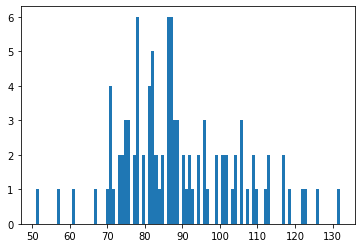

In [13]:
plt.hist(iter_terminate_list,100)

(array([ 3.,  5.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  3., 85.]),
 array([0.49251465, 0.49751274, 0.50251084, 0.50750893, 0.51250703,
        0.51750512, 0.52250322, 0.52750131, 0.53249941, 0.5374975 ,
        0.5424956 , 0.54749369, 0.55249179, 0.55748989, 0.56248798,
        0.56748608, 0.57248417, 0.57748227, 0.58248036, 0.58747846,
        0.59247655, 0.59747465, 0.60247274, 0.60747084, 0.61246893,
        0.61746703, 0.62246512, 0.62746322, 0.63246131, 0.63745941,
        0.6424575 , 0.6474

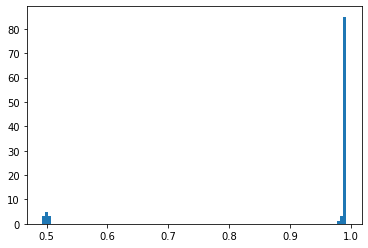

In [14]:
prb_last_list_real = [i.real for i in prb_last_list]
plt.hist(prb_last_list_real,100)

In [15]:
print('time now: ', end_time)

time now:  2022-11-23 10:50:07.213577


## 1 layers

In [21]:
max_repeat = 100 #100
iter_max = 300  #300
num_of_layers = 1
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []
debug_flag, print_flag = 0, True
start_time = datetime.datetime.now()
for rep in range(1,max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')
    
    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta=qml_np.random.uniform(0, 2*math.pi, size=(num_of_layers, num_of_qubits-1), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate=iter_max
    for iter in range(1, iter_max+1):    
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter>=2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val: # eps_val=1e-10
            if abs( (val1-val1_old)/val1 ) < tiny_change_threshold: # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change: # no change for a consequtive of 5 iterations, then break
            break_flag = True
        if (iter==1 or iter%20==0 or iter==iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
                 :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
                 :: theta={theta}')
#             print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
#                  :: val1_2={val1_2:12.8f} :: val2={val2:12.8f}  \
#                  coef2*val2-0.5*(val1_1 - val1_2)={coef2*val2-0.5*(val1_1 - val1_2):12.8f}  \
#                  :: theta={theta}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: theta={theta}')
        obj_list.append(obj)
        if break_flag:
            iter_terminate=iter
            break
    theta_list.append(theta)
    print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)
    
    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')
    
    print('val_global=')
    print(val_global)
    val_global = [] # reset to empty
    
    ## display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]
    # print(f'state={state}')
    if len(prb)>20:
        print(f'prb(last 2)={prb[-2:]}')
    else: print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])
print('theta_list=', theta_list)
print('iter_terminate_list=', iter_terminate_list)
print('prb_last_list=', prb_last_list)    
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()
print(f'time consumed: {duration_in_s}s')



rep=1
iter=  1 :: obj= -0.03413574 :: val1_1=  0.03929590                  :: val1_2= -0.02897558 :: -0.5*(val1_1 - val1_2)= -0.03413574                   :: theta=[[5.32948068 2.02202764 2.27865713 4.68395322 2.6114149  2.80328916
  3.6116287  2.26820969 3.23130992]]
iter= 20 :: obj= -0.06344480 :: val1_1=  0.07546694                  :: val1_2= -0.05142266 :: -0.5*(val1_1 - val1_2)= -0.06344480                   :: theta=[[5.05271361 2.73860603 2.84724692 3.74090236 2.76015714 2.67606402
  2.74104333 2.84579384 3.62149604]]
iter= 40 :: obj= -0.07034897 :: val1_1=  0.08150269                  :: val1_2= -0.05919525 :: -0.5*(val1_1 - val1_2)= -0.07034897                   :: theta=[[5.02076069 2.84926739 2.79229912 3.00895592 2.84869875 2.85664575
  2.77300846 2.79270964 3.4726171 ]]
obj_list(last 3)=[-0.07068305581640644, -0.07067896720373401, -0.07067424452240711]
time consumed: 2.510977s, after for-iter
val_global=
[[0.03929590341395528, -0.02897557876836032, -0.0341357410911578],

In [26]:
print('theta_list=', theta_list)
print('iter_terminate_list=', iter_terminate_list)
print('prb_last_list=', prb_last_list)  

theta_list= [tensor([[5.0192325 , 2.80882519, 2.84888183, 2.80244241, 2.82376691,
         2.81843258, 2.89238696, 2.84747772, 3.44144944]], requires_grad=True), tensor([[ 3.13007787,  4.71977823,  4.71923483,  4.72463198,  4.72031989,
         -1.53447608,  4.69828449,  4.78045676,  1.55370922]], requires_grad=True), tensor([[ 3.14758726, -1.55661118, -1.52220262,  4.7205201 ,  4.72239247,
          4.71483945, -1.5218941 ,  4.70990507,  1.56197117]], requires_grad=True), tensor([[-3.16011982,  4.72959823,  4.72595347,  4.73514443, -1.54390937,
          4.71304765,  4.73017402,  4.7299143 ,  7.82179099]], requires_grad=True), tensor([[ 3.10253862, -1.60364093,  4.71383649,  4.72070807,  4.71735397,
          4.71484064, -1.51100536,  4.75146483,  7.78773974]], requires_grad=True), tensor([[ 3.13019332, -1.51471313,  4.72634443,  4.7129547 ,  4.73301128,
          4.72333569, -1.51476069, -1.51403932,  1.56903146]], requires_grad=True), tensor([[ 3.13459379,  4.7345531 ,  4.69503808, 

(array([2., 0., 0., 1., 1., 0., 2., 2., 4., 7., 2., 6., 9., 7., 5., 9., 8.,
        6., 4., 5., 2., 5., 1., 2., 0., 0., 0., 2., 1., 0., 0., 2., 1., 1.,
        0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 53.  ,  55.47,  57.94,  60.41,  62.88,  65.35,  67.82,  70.29,
         72.76,  75.23,  77.7 ,  80.17,  82.64,  85.11,  87.58,  90.05,
         92.52,  94.99,  97.46,  99.93, 102.4 , 104.87, 107.34, 109.81,
        112.28, 114.75, 117.22, 119.69, 122.16, 124.63, 127.1 , 129.57,
        132.04, 134.51, 136.98, 139.45, 141.92, 144.39, 146.86, 149.33,
        151.8 , 154.27, 156.74, 159.21, 161.68, 164.15, 166.62, 169.09,
        171.56, 174.03, 176.5 , 178.97, 181.44, 183.91, 186.38, 188.85,
        191.32, 193.79, 196.26, 198.73, 201.2 

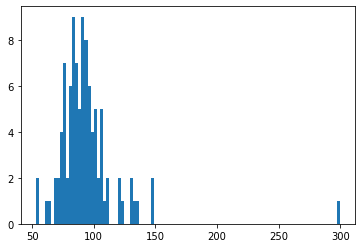

In [27]:
plt.hist(iter_terminate_list,100)

(array([24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 73.]),
 array([7.78458426e-07, 9.92376713e-03, 1.98467558e-02, 2.97697445e-02,
        3.96927332e-02, 4.96157218e-02, 5.95387105e-02, 6.94616992e-02,
        7.93846878e-02, 8.93076765e-02, 9.92306652e-02, 1.09153654e-01,
        1.19076643e-01, 1.28999631e-01, 1.38922620e-01, 1.48845609e-01,
        1.58768597e-01, 1.68691586e-01, 1.78614575e-01, 1.88537563e-01,
        1.98460552e-01, 2.08383541e-01, 2.18306529e-01, 2.28229518e-01,
  

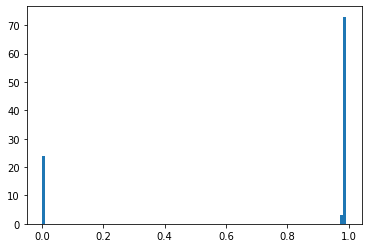

In [28]:
prb_last_list_real = [i.real for i in prb_last_list]
plt.hist(prb_last_list_real,100)

In [29]:
print('time now: ', end_time)

time now:  2022-11-23 14:11:22.025016


# functions for verification

In [19]:
dev_no_HT_S=qml.device(device_name2, wires=num_of_qubits-1)  
@qml.qnode(dev_no_HT_S)
def quantum_circuit_ansatz_XH(theta):
    n = len(theta[0])
    for theta_i in theta:
        layer_no_HT(theta_i, list(range(num_of_qubits-1)))  
    for i in range(0,n):
        qml.PauliX(i)  
    for i in range(1,n):
        qml.Hadamard(i)
    return qml.state()
print(qml.draw(quantum_circuit_ansatz_XH)([[1,2,3,4,5,6,7,8,9]]))

0: ──RY(1.00)─╭●──X─────────────────────────┤  State
1: ──RY(2.00)─╰X─╭●──X──H───────────────────┤  State
2: ──RY(3.00)────╰X─╭●──X──H────────────────┤  State
3: ──RY(4.00)───────╰X─╭●──X──H─────────────┤  State
4: ──RY(5.00)──────────╰X─╭●──X──H──────────┤  State
5: ──RY(6.00)─────────────╰X─╭●──X──H───────┤  State
6: ──RY(7.00)────────────────╰X─╭●──X──H────┤  State
7: ──RY(8.00)───────────────────╰X─╭●──X──H─┤  State
8: ──RY(9.00)──────────────────────╰X──X──H─┤  State


In [28]:

def quantum_circuit_ansatz_XH_matrix(theta):
    n = len(theta[0])
    for theta_i in theta:
        layer_no_HT(theta_i, list(range(num_of_qubits-1)))  
    for i in range(0,n):
        qml.PauliX(i)  
    for i in range(1,n):
        qml.Hadamard(i)
theta = [[1,2,3,4,5,6,7,8,9]]
matrix_fn = qml.matrix(quantum_circuit_ansatz_XH_matrix)
matrix_result = matrix_fn(theta)


In [29]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(matrix_fn(theta))

np.savetxt('result.txt', matrix_result, fmt='%.2e')

# 1 layer, verify id 1
- 2nd result from 1 layer results given above, prb=0.9910745861103757

In [12]:
theta = [[ 3.13007787,  4.71977823,  4.71923483,  4.72463198,  4.72031989,
         -1.53447608,  4.69828449,  4.78045676,  1.55370922]]
# theta = tensor([[ 3.13007787,  4.71977823,  4.71923483,  4.72463198,  4.72031989,
#          -1.53447608,  4.69828449,  4.78045676,  1.55370922]], requires_grad=True)
quantum_circuit_no_HT_return_state(theta)

tensor([-3.66734032e-03+0.j,  2.09897744e-03+0.j, -3.71521717e-03+0.j,
        -3.97680578e-03+0.j, -3.92276855e-03+0.j, -3.85767564e-03+0.j,
        -3.64291837e-03+0.j, -3.66478195e-03+0.j, -3.80001171e-03+0.j,
        -3.73635962e-03+0.j, -3.99898760e-03+0.j, -4.06788394e-03+0.j,
        -4.12563722e-03+0.j, -4.05221023e-03+0.j, -3.68420940e-03+0.j,
        -3.85309149e-03+0.j, -3.88466803e-03+0.j, -3.81844018e-03+0.j,
        -4.08804743e-03+0.j, -4.15851823e-03+0.j, -4.10027435e-03+0.j,
        -4.03080446e-03+0.j, -3.76537072e-03+0.j, -3.83026308e-03+0.j,
        -3.69361488e-03+0.j, -3.63119435e-03+0.j, -3.88700572e-03+0.j,
        -3.95399185e-03+0.j, -4.01015124e-03+0.j, -3.94143804e-03+0.j,
        -3.65980056e-03+0.j, -3.74588603e-03+0.j, -3.79222606e-03+0.j,
        -3.72783679e-03+0.j, -3.99077236e-03+0.j, -4.05955721e-03+0.j,
        -4.00269930e-03+0.j, -3.93488253e-03+0.j, -3.67576357e-03+0.j,
        -3.73911352e-03+0.j, -3.87744639e-03+0.j, -3.81175173e-03+0.j,
      